In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import pandas as pd
df = pd.read_csv('final_data.csv')
df.columns

Index(['Category', 'Review'], dtype='object')

In [ ]:
!pip install transformers

In [ ]:
!pip install scikit-learn


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-8-5333c7139a5e>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

Epoch 1/3, Train Loss: 0.2762, Train Accuracy: 0.9233, Val Loss: 0.2496, Val Accuracy: 0.9313
Epoch 2/3, Train Loss: 0.2722, Train Accuracy: 0.9248, Val Loss: 0.2613, Val Accuracy: 0.9313
Epoch 3/3, Train Loss: 0.2706, Train Accuracy: 0.9248, Val Loss: 0.2508, Val Accuracy: 0.9313
Test Accuracy: 0.9248593181065872


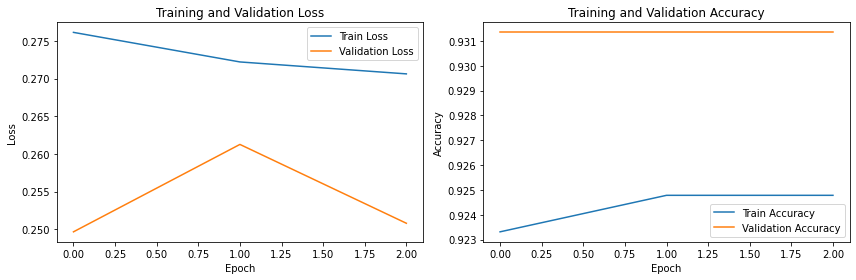

In [8]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt


# Split the dataset into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Tokenize the text data
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
train_encodings = tokenizer(list(train_df['Review']), truncation=True, padding=True, max_length=256, return_tensors='pt')
val_encodings = tokenizer(list(val_df['Review']), truncation=True, padding=True, max_length=256, return_tensors='pt')
test_encodings = tokenizer(list(test_df['Review']), truncation=True, padding=True, max_length=256, return_tensors='pt')

# Create custom dataset
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, list(train_df['Category']))
val_dataset = CustomDataset(val_encodings, list(val_df['Category']))
test_dataset = CustomDataset(test_encodings, list(test_df['Category']))

# Initialize RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('roberta-large')

# Initialize optimizer and criterion
optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()

# Create DataLoader for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Training loop
num_epochs = 3
device = torch.device('cuda:0' )
model.to(device)

# Training loop
num_epochs = 3
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        _, predicted = outputs.logits.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    train_accuracy = correct_train / total_train
    train_losses.append(epoch_train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    epoch_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            epoch_val_loss += loss.item()
            _, predicted = outputs.logits.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    val_accuracy = correct_val / total_val
    val_losses.append(epoch_val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Testing
model.eval()
test_predictions = []
test_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted_labels = torch.max(logits, 1)
        test_predictions.extend(predicted_labels.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Calculate test accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Test Accuracy: {test_accuracy}')

# Plotting
plt.figure(figsize=(12, 4))

# Loss plots
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Roberta3-epoch_vs_loss.png')


# Accuracy plots
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Roberta3-epoch_vs_accuracy.png')

plt.tight_layout()
plt.show()


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt



# Split the dataset into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Tokenize the text data
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
train_encodings = tokenizer(list(train_df['Review']), truncation=True, padding=True, max_length=256, return_tensors='pt')
val_encodings = tokenizer(list(val_df['Review']), truncation=True, padding=True, max_length=256, return_tensors='pt')
test_encodings = tokenizer(list(test_df['Review']), truncation=True, padding=True, max_length=256, return_tensors='pt')

# Create custom dataset
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)  # Make sure labels are of type long
        return item

    def __len__(self):
        return len(self.labels)


# Create custom dataset
train_dataset = CustomDataset(train_encodings, list(train_df['Category']))
val_dataset = CustomDataset(val_encodings, list(val_df['Category']))
test_dataset = CustomDataset(test_encodings, list(test_df['Category']))



import torch.nn.functional as F

class CustomLoss(torch.nn.Module):
    def __init__(self, alpha=0.5):
        super(CustomLoss, self).__init__()
        self.alpha = alpha  # Weight for the MSE loss

    def forward(self, logits, labels):
        # CrossEntropyLoss
        ce_loss = F.cross_entropy(logits, labels)

        # Convert labels to one-hot encoding for MSE loss
        one_hot_labels = F.one_hot(labels, num_classes=logits.size(-1)).float()

        # Compute MSE loss
        mse_loss = F.mse_loss(F.softmax(logits, dim=-1), one_hot_labels)

        # Combine losses with the specified weight
        combined_loss = self.alpha * mse_loss + (1 - self.alpha) * ce_loss

        return combined_loss







# Initialize RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('roberta-large')

# Initialize optimizer and criterion
optimizer = AdamW(model.parameters(), lr=1e-5)
custom_criterion = CustomLoss()

# Create DataLoader for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Training loop
num_epochs = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop
num_epochs = 3
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = custom_criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        _, predicted = outputs.logits.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    train_accuracy = correct_train / total_train
    train_losses.append(epoch_train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    epoch_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            epoch_val_loss += loss.item()
            _, predicted = outputs.logits.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    val_accuracy = correct_val / total_val
    val_losses.append(epoch_val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Testing
model.eval()
test_predictions = []
test_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted_labels = torch.max(logits, 1)
        test_predictions.extend(predicted_labels.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Calculate test accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Test Accuracy: {test_accuracy}')

# Plotting
plt.figure(figsize=(12, 4))

# Loss plots
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Roberta3(loss)-epoch_vs_loss.png')


# Accuracy plots
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Roberta3(loss)-epoch_vs_accuracy.png')


plt.tight_layout()
plt.show()



In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Assuming you have a DataFrame df with columns 'Review' and 'Category'
df = pd.read_csv('final_data.csv')

# Split the dataset into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = str(self.reviews[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(
            review,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Initialize the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
model = RobertaForSequenceClassification.from_pretrained('roberta-large', num_labels=len(df['Category'].unique()))

# Define training parameters
epochs = 100
batch_size = 16
learning_rate = 1e-5

# Initialize optimizers
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Define your custom loss function
class CustomLoss(torch.nn.Module):
    def __init__(self, alpha=0.5):
        super(CustomLoss, self).__init__()
        self.alpha = alpha  # Weight for the MSE loss

    def forward(self, logits, labels):
        # CrossEntropyLoss
        ce_loss = F.cross_entropy(logits, labels)

        # Convert labels to one-hot encoding for MSE loss
        one_hot_labels = F.one_hot(labels, num_classes=logits.size(-1)).float()

        # Compute MSE loss
        mse_loss = F.mse_loss(F.softmax(logits, dim=-1), one_hot_labels)

        # Combine losses with the specified weight
        combined_loss = self.alpha * mse_loss + (1 - self.alpha) * ce_loss

        return ce_loss, mse_loss

# Create DataLoader for train, validation, and test sets
train_dataset = CustomDataset(train_df['Review'], train_df['Category'], tokenizer, max_len=512)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomDataset(val_df['Review'], val_df['Category'], tokenizer, max_len=512)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Lists to store training statistics
train_losses_ce = []
train_losses_custom = []
val_losses_ce = []
val_losses_custom = []

# Training loop
for epoch in range(epochs):
    model.train()
    total_train_loss_ce = 0.0
    total_train_loss_custom = 0.0

    for batch in train_loader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits

        # Compute cross-entropy loss and your custom loss separately
        criterion = CustomLoss(alpha=0.5)
        loss_ce, loss_custom = criterion(logits, labels)

        loss_ce.backward(retain_graph=True)
        optimizer.step()

        loss_custom.backward()
        optimizer.step()

        total_train_loss_ce += loss_ce.item()
        total_train_loss_custom += loss_custom.item()

    avg_train_loss_ce = total_train_loss_ce / len(train_loader)
    avg_train_loss_custom = total_train_loss_custom / len(train_loader)

    # Validation loop
    model.eval()
    total_val_loss_ce = 0.0
    total_val_loss_custom = 0.0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['label']

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits

            # Compute cross-entropy loss and your custom loss separately
            loss_ce, loss_custom = criterion(logits, labels)

            total_val_loss_ce += loss_ce.item()
            total_val_loss_custom += loss_custom.item()

    avg_val_loss_ce = total_val_loss_ce / len(val_loader)
    avg_val_loss_custom = total_val_loss_custom / len(val_loader)

    # Append losses for plotting
    train_losses_ce.append(avg_train_loss_ce)
    train_losses_custom.append(avg_train_loss_custom)
    val_losses_ce.append(avg_val_loss_ce)
    val_losses_custom.append(avg_val_loss_custom)

    print(f'Epoch {epoch + 1}/{epochs} => '
          f'Train CE Loss: {avg_train_loss_ce:.4f}, Train Custom Loss: {avg_train_loss_custom:.4f}, '
          f'Val CE Loss: {avg_val_loss_ce:.4f}, Val Custom Loss: {avg_val_loss_custom:.4f}')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses_ce, label='Train CE Loss')
plt.plot(train_losses_custom, label='Train Custom Loss')
plt.plot(val_losses_ce, label='Validation CE Loss')
plt.plot(val_losses_custom, label='Validation Custom Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.savefig('Roberta100(Custom,CE)epochs_vs_loss.png')
plt.show()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-35-98ee8a7e4290>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 1/100 => Train CE Loss: 0.2120, Train Custom Loss: 0.1340, Val CE Loss: 0.1531, Val Custom Loss: 0.0965
Epoch 2/100 => Train CE Loss: 0.2173, Train Custom Loss: 0.1369, Val CE Loss: 0.2491, Val Custom Loss: 0.1564
Epoch 3/100 => Train CE Loss: 0.2721, Train Custom Loss: 0.1712, Val CE Loss: 0.2478, Val Custom Loss: 0.1556
Epoch 4/100 => Train CE Loss: 0.2722, Train Custom Loss: 0.1713, Val CE Loss: 0.2497, Val Custom Loss: 0.1567
Epoch 5/100 => Train CE Loss: 0.2703, Train Custom Loss: 0.1702, Val CE Loss: 0.2492, Val Custom Loss: 0.1564
Epoch 6/100 => Train CE Loss: 0.2710, Train Custom Loss: 0.1706, Val CE Loss: 0.2496, Val Custom Loss: 0.1566
Epoch 7/100 => Train CE Loss: 0.2703, Train Custom Loss: 0.1702, Val CE Loss: 0.2569, Val Custom Loss: 0.1606
Epoch 8/100 => Train CE Loss: 0.2704, Train Custom Loss: 0.1702, Val CE Loss: 0.2508, Val Custom Loss: 0.1573
Epoch 9/100 => Train CE Loss: 0.2704, Train Custom Loss: 0.1702, Val CE Loss: 0.2491, Val Custom Loss: 0.1564
Epoch 10/1

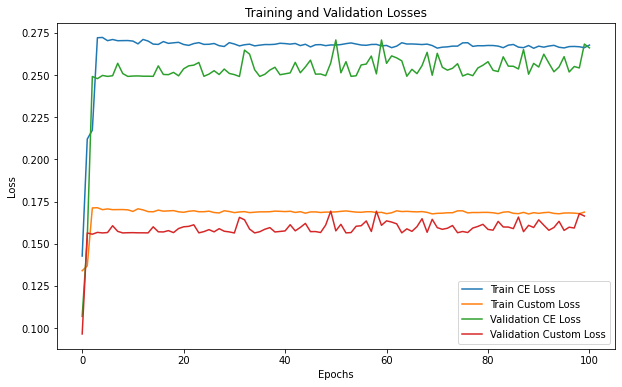

In [35]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import matplotlib.pyplot as plt


# Split the dataset into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Tokenize the text data
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
train_encodings = tokenizer(list(train_df['Review']), truncation=True, padding=True, max_length=256, return_tensors='pt')
val_encodings = tokenizer(list(val_df['Review']), truncation=True, padding=True, max_length=256, return_tensors='pt')
test_encodings = tokenizer(list(test_df['Review']), truncation=True, padding=True, max_length=256, return_tensors='pt')

# Extract tensors from encodings
train_encodings = {key: tensor.squeeze() for key, tensor in train_encodings.items()}
val_encodings = {key: tensor.squeeze() for key, tensor in val_encodings.items()}
test_encodings = {key: tensor.squeeze() for key, tensor in test_encodings.items()}

# Create custom dataset
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)  # Make sure labels are of type long
        return item

    def __len__(self):
        return len(self.labels)

# Create custom dataset
train_dataset = CustomDataset(train_encodings, list(train_df['Category']))
val_dataset = CustomDataset(val_encodings, list(val_df['Category']))
test_dataset = CustomDataset(test_encodings, list(test_df['Category']))

# Define the custom loss function
class CustomLoss(torch.nn.Module):
    def __init__(self, alpha=0.5):
        super(CustomLoss, self).__init__()
        self.alpha = alpha  # Weight for the MSE loss

    def forward(self, logits, labels):
        # CrossEntropyLoss
        ce_loss = F.cross_entropy(logits, labels)

        # Convert labels to one-hot encoding for MSE loss
        one_hot_labels = F.one_hot(labels, num_classes=logits.size(-1)).float()

        # Compute MSE loss
        mse_loss = F.mse_loss(F.softmax(logits, dim=-1), one_hot_labels)

        # Combine losses with the specified weight
        combined_loss = self.alpha * mse_loss + (1 - self.alpha) * ce_loss

        return combined_loss

# Initialize RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('roberta-large')

# Initialize optimizer and criterion
optimizer = AdamW(model.parameters(), lr=1e-5)
custom_criterion = CustomLoss()

# Create DataLoader for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
custom_criterion.to(device)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_train_loss_ce = 0.0
    total_train_loss_custom = 0.0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits

        # Calculate CrossEntropy loss
        ce_loss = F.cross_entropy(logits, labels)

        # Calculate custom loss
        custom_loss = custom_criterion(logits, labels)

        # Backward pass and optimization
        ce_loss.backward(retain_graph=True)
        custom_loss.backward()

        optimizer.step()

        total_train_loss_ce += ce_loss.item()
        total_train_loss_custom += custom_loss.item()

    avg_train_loss_ce = total_train_loss_ce / len(train_loader)
    avg_train_loss_custom = total_train_loss_custom / len(train_loader)

    # Validation loop
    model.eval()
    total_val_loss_ce = 0.0
    total_val_loss_custom = 0.0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits

            # Calculate CrossEntropy loss
            ce_loss = F.cross_entropy(logits, labels)

            # Calculate custom loss
            custom_loss = custom_criterion(logits, labels)

            total_val_loss_ce += ce_loss.item()
            total_val_loss_custom += custom_loss.item()

    avg_val_loss_ce = total_val_loss_ce / len(val_loader)
    avg_val_loss_custom = total_val_loss_custom / len(val_loader)

    # Append losses for plotting
    train_losses_ce.append(avg_train_loss_ce)
    train_losses_custom.append(avg_train_loss_custom)
    val_losses_ce.append(avg_val_loss_ce)
    val_losses_custom.append(avg_val_loss_custom)

    print(f'Epoch {epoch + 1}/{num_epochs} => '
          f'Train CE Loss: {avg_train_loss_ce:.4f}, Train Custom Loss: {avg_train_loss_custom:.4f}, '
          f'Val CE Loss: {avg_val_loss_ce:.4f}, Val Custom Loss: {avg_val_loss_custom:.4f}')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses_ce, label='Train CE Loss')
plt.plot(train_losses_custom, label='Train Custom Loss')
plt.plot(val_losses_ce, label='Validation CE Loss')
plt.plot(val_losses_custom, label='Validation Custom Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.savefig('Roberta100_CE_Custom_epochs_vs_loss.png')
plt.show()

In [38]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.model_selection import ParameterGrid

df = pd.read_csv('final_data.csv')

# Split the dataset into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Tokenize the text data
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
train_encodings = tokenizer(list(train_df['Review']), truncation=True, padding=True, max_length=256, return_tensors='pt')
val_encodings = tokenizer(list(val_df['Review']), truncation=True, padding=True, max_length=256, return_tensors='pt')
test_encodings = tokenizer(list(test_df['Review']), truncation=True, padding=True, max_length=256, return_tensors='pt')

# Define the parameter grid for grid search
param_grid = {
    'lr': [1e-5],
    'batch_size': [16],
    'num_epochs': [3],
    'sampling_strategy': [0.2],
    'model_name': ['roberta-large']
}

# Create combinations of hyperparameters
param_combinations = list(ParameterGrid(param_grid))

# Initialize results list
results = []

# Define the CustomDataset class
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Define the training, validation, and test datasets
train_dataset = CustomDataset(train_encodings, list(train_df['Category']))
val_dataset = CustomDataset(val_encodings, list(val_df['Category']))
test_dataset = CustomDataset(test_encodings, list(test_df['Category']))

# Grid search
for params in param_combinations:
    # Apply SMOTE to the training data with the current parameters
    smote = SMOTE(sampling_strategy=params['sampling_strategy'], random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(train_encodings['input_ids'], list(train_df['Category']))
    
    # Ensure that the number of resampled samples does not exceed the length of the original training set
    X_train_resampled = X_train_resampled[:len(train_df)]
    y_train_resampled = y_train_resampled[:len(train_df)]
    
    # Convert resampled data to PyTorch tensors
    train_encodings_resampled = {'input_ids': torch.tensor(X_train_resampled),
                                  'attention_mask': train_encodings['attention_mask'][:len(X_train_resampled)]}

    # Initialize the RoBERTa model
    model = RobertaForSequenceClassification.from_pretrained(params['model_name'])
    
    # Initialize optimizer and criterion
    optimizer = AdamW(model.parameters(), lr=params['lr'])
    criterion = torch.nn.CrossEntropyLoss()

    # Create DataLoader for training and validation sets
    train_loader = DataLoader(CustomDataset(train_encodings_resampled, y_train_resampled), batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    # Training loop
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_model = None
    best_val_accuracy = 0.0
    
    for epoch in range(params['num_epochs']):
        model.train()
        epoch_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            _, predicted = outputs.logits.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        train_accuracy = correct_train / total_train
        train_losses.append(epoch_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        epoch_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss

                epoch_val_loss += loss.item()
                _, predicted = outputs.logits.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()

        val_accuracy = correct_val / total_val
        val_losses.append(epoch_val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)

    # Store results
    result_entry = {
        'params': params,
        'train_accuracy': train_accuracies[-1],
        'val_accuracy': val_accuracies[-1]
    }
    results.append(result_entry)

    if val_accuracies[-1] > best_val_accuracy:
        best_val_accuracy = val_accuracies[-1]
        # Initialize the best model outside the loop
        best_model = RobertaForSequenceClassification.from_pretrained(params['model_name'])
        best_model.to(device)
        best_model.load_state_dict(model.state_dict())

# Display results
results_df = pd.DataFrame(results)
print(results_df)

# Find the row with the highest validation accuracy
best_model_idx = results_df['val_accuracy'].idxmax()

# Display the best model parameters and accuracy
best_model_params = results_df.loc[best_model_idx, 'params']
best_model_train_accuracy = results_df.loc[best_model_idx, 'train_accuracy']
best_model_val_accuracy = results_df.loc[best_model_idx, 'val_accuracy']

print("\nBest Model Parameters:")
print(best_model_params)
print(f"Best Model Training Accuracy: {best_model_train_accuracy:.4f}")
print(f"Best Model Validation Accuracy: {best_model_val_accuracy:.4f}")

# Use the best model on the test set
# Testing using the best model
best_model.eval()
test_predictions = []
test_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = best_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted_labels = torch.max(logits, 1)
        test_predictions.extend(predicted_labels.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Calculate test accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Test Accuracy using the Best Model: {test_accuracy:.4f}')


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-38-6cbe7df59b0f>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()

                                              params  train_accuracy  \
0  {'batch_size': 16, 'lr': 1e-05, 'model_name': ...        0.960736   

   val_accuracy  
0      0.950372  

Best Model Parameters:
{'batch_size': 16, 'lr': 1e-05, 'model_name': 'roberta-large', 'num_epochs': 3, 'sampling_strategy': 0.2}
Best Model Training Accuracy: 0.9607
Best Model Validation Accuracy: 0.9504
Test Accuracy using the Best Model: 0.9543
